# Installers



In [ ]:
!pip install geopandas shapely pyproj

In [ ]:
!pip install pandas numpy matplotlib statsmodels scipy pmdarima

# Imports

In [ ]:
# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from IPython.display import display

# Data handling
import pandas as pd
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pandas.io.json import json_normalize
import geopandas as gpd
import numpy as np
import time
from google.colab import drive
import re
from pathlib import Path

# Models
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.tsa.stattools as smt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

This function creates a monthly time series DataFrame grouped by a specified column, ensuring a complete date range from start_date to end_date.

In [ ]:
def grouped_timeseries(df, group_col, start_date, end_date):
    """
    Args:
    df (pd.DataFrame): The DataFrame to process.
    group_col (str): The name of the column to group by (e.g., 'gender').
    start_date (str): The start date for the time series index.
    end_date (str): The end date for the time series index.

    Returns:
    pd.DataFrame: A DataFrame with a monthly time series for each group.
    """
    # Ensure 'date' column is datetime
    df['date'] = pd.to_datetime(df['date'])

    # Define the complete time range for the index
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS').to_period('M').to_timestamp('M')

    # Group by the specified column and date, then count occurrences
    grouped = df.groupby([pd.Grouper(key='date', freq='M'), group_col]).size()

    # Unstack to create separate columns for each group
    grouped_unstacked = grouped.unstack(level=group_col)

    # Reindex to ensure the DataFrame covers the full date range
    grouped_unstacked = grouped_unstacked.reindex(date_range, fill_value=0)

    return grouped_unstacked

This function plots the trend data from Mortality Records by subset/group.

In [ ]:
def plot_mortality_data(df, subset_name):
    """
    Args:
    df (pd.DataFrame): The DataFrame with trend data to be plotted.
    subset_name (str): The subset name to include in the plot title.
    """
    # Set the style of the seaborn plot
    sns.set(style='whitegrid')

    # Set the size of the figure
    plt.figure(figsize=(10, 4))

    # Define a list of distinct colors for each column
    colors = sns.color_palette('husl', n_colors=len(df.columns))

    # Plot each column in the DataFrame using the colors list
    for (column, color) in zip(df.columns, colors):
        plt.plot(df.index, df[column], label=column, color=color, lw=1.5, linestyle=':')

    # Adding title and labels
    plt.title(f'Suicides by {subset_name}', fontsize=11)
    plt.xlabel('Date', fontsize=9)
    plt.ylabel('Monthly Count', fontsize=9)

    # Add a legend to the plot outside the plot area
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

    # Show the plot
    plt.show()

This function fits both an ARIMA and a SARIMA model to the provided time series data and selects the best model based on AIC/BIC. Then extract the residuals of the best fitted model.
    

In [ ]:
def fit_model_and_extract_residuals(df, seasonal_period=12):
    """
    Args:
    df (pd.DataFrame): A DataFrame with the time series data in the first column.
    seasonal_period (int): The number of time steps for a single seasonal period.

    Returns:
    pd.DataFrame: A DataFrame containing the residuals of the best-fit model for the entire dataset.
    """
    # Extract the time series (assuming it's the first column)
    time_series = df.iloc[:, 0]

    # Fit ARIMA model (non-seasonal)
    arima_model = pm.auto_arima(time_series, seasonal=False, trace=True,
                                error_action='ignore', suppress_warnings=True,
                                stepwise=True)

    # Fit SARIMA model (seasonal)
    sarima_model = pm.auto_arima(time_series, seasonal=True, m=seasonal_period,
                                 trace=True, error_action='ignore', suppress_warnings=True,
                                 stepwise=True)

    # Choose the model with the lower AIC/BIC
    best_model = sarima_model if sarima_model.aic() < arima_model.aic() else arima_model
    model_type = "SARIMA" if best_model is sarima_model else "ARIMA"

    # Extract residuals and create a DataFrame with model parameters in the column name
    column_name = f'{model_type} ({best_model.order})'
    if model_type == "SARIMA":
        column_name += f'({best_model.seasonal_order})'
    residuals = pd.DataFrame(best_model.resid(), index=df.index, columns=[column_name])

    return residuals

This function plots the residuals of a fitted time series model.

In [ ]:
def plot_residuals(residuals_df, subset_name):
    """
    Args:
    residuals_df (pd.DataFrame): The DataFrame containing the residuals to be plotted. The column name should include the model name and its parameters.
    category_name (str): The category name to include in the plot title.
    """
    # Extract model name and parameters from the column name
    model_info = residuals_df.columns[0]

    # Set the size of the figure
    plt.figure(figsize=(10, 6))

    # Plot the residuals
    plt.plot(residuals_df, color='purple', lw=1.5)

    # Adding title and labels
    plt.title(f'{model_info} - {subset_name}  ', fontsize=11)
    plt.xlabel('Date', fontsize=9)
    plt.ylabel('Residuals', fontsize=9)

    # Show the plot
    plt.show()

# Raw Data

In [ ]:
# Load Ecuador's provinces Shape file
ecu_shp = gpd.read_file("/content/drive/MyDrive/Diversa/PUCE/shp_Ecuador/nxprovincias.shp")
if ecu_shp.crs is None:
    ecu_shp.crs = 'epsg:32717'
ecu_shp = ecu_shp.to_crs('epsg:4326')
ecu_shp = ecu_shp[['DPA_PROVIN', 'geometry']]

# Load mortality records (INEC, 2022)
archivo_xlsx = '/content/drive/MyDrive/Diversa/PUCE/base suicidios.xlsx'
mortality = pd.read_excel(archivo_xlsx)
mortality.head()

,provincia,fuente1,sexo,año_f,mes_fall,mes_fall1,edad,cod_eda,cau,cau1d,cau2d,cau3d,año,edad2,n,cie10_des,GBD,FECHA
0,02 Bolívar,EDG_2011,Mujer,2011,7,7,26,4 Años (1 a 115 años de edad),X609,X,X6,X60,2011,26,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2011-07-28
1,02 Bolívar,EDG_2011,Hombre,2011,8,8,23,4 Años (1 a 115 años de edad),X609,X,X6,X60,2011,23,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2011-08-28
2,18 Tungurahua,EDG_2012,Mujer,2012,6,6,14,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,14,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-06-28
3,16 Pastaza,EDG_2012,Hombre,2012,2,2,21,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,21,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-02-28
4,16 Pastaza,EDG_2012,Hombre,2012,2,2,34,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,34,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-02-28


In [ ]:
mortality.tail()

,provincia,fuente1,sexo,año_f,mes_fall,mes_fall1,edad,cod_eda,cau,cau1d,cau2d,cau3d,año,edad2,n,cie10_des,GBD,FECHA
12876,09 Guayas,EDG_2021,Hombre,2021,Marzo,3,93,4 Años (1 a 115 años de edad),X800,X,X8,X80,2021,93,1,X800 Lesión autoinfligida intencionalmente al ...,Causas externas de mortalidad y morbilidad,2021-03-28
12877,07 El Oro,EDG_2021,Hombre,2021,Marzo,3,35,4 Años (1 a 115 años de edad),X804,X,X8,X80,2021,35,1,X804 Lesión autoinfligida intencionalmente al ...,Causas externas de mortalidad y morbilidad,2021-03-28
12878,07 El Oro,EDG_2021,Hombre,2021,Julio,7,29,4 Años (1 a 115 años de edad),X808,X,X8,X80,2021,29,1,X808 Lesión autoinfligida intencionalmente al ...,Causas externas de mortalidad y morbilidad,2021-07-28
12879,10 Imbabura,EDG_2021,Mujer,2021,Abril,4,21,4 Años (1 a 115 años de edad),X800,X,X8,X80,2021,21,1,X800 Lesión autoinfligida intencionalmente al ...,Causas externas de mortalidad y morbilidad,2021-04-28
12880,01 Azuay,EDG_2021,Mujer,2021,Abril,4,69,4 Años (1 a 115 años de edad),X800,X,X8,X80,2021,69,1,X800 Lesión autoinfligida intencionalmente al ...,Causas externas de mortalidad y morbilidad,2021-04-28


# Data cleansing and preparation

In [ ]:
## Subset & clean names/labels

# Rename
column_names_in_english = {
    'provincia': 'province',
    'sexo': 'gender',
    'edad': 'age',
    'cie10_des': 'description',
    'FECHA': 'date'
}
mortality.rename(columns=column_names_in_english, inplace=True)

# Clean Description
mortality['description'] = mortality['description'].str.extract(' (.*)')
description_translation = {
    'Envenenamiento autoinfligido intencionalmente por': 'Self-poisoning',
    'Lesión autoinfligida intencionalmente por ahorcamiento': 'Self-hanging',
    'Lesión autoinfligida intencionalmente por objeto cortante': 'Self-harm with sharp object',
    'Lesión autoinfligida intencionalmente al saltar desde un lugar elevado': 'Self-harm by jumping from high place'
}
mortality['description'] = mortality['description'].replace(description_translation)

# Make age range
mortality['age'] = mortality['age'].replace(999, 99)
age_bins = [0, 19, 39, 64, 150]
age_labels = [
    "Teens and Infants (0-19)",
    "Young Adults (20-39)",
    "Adults (40-64)",
    "Seniors (65+)"
]
# Apply the new bins and labels to the 'age' column to create the 'age_range' column
mortality['age_range'] = pd.cut(mortality['age'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)


# Clean gender
gender_translation = {
    'Hombre': 'M',
    'Mujer': 'F'
}
mortality['gender'] = mortality['gender'].replace(gender_translation)

# Clean province and get the geometry
mortality['province_code'] = mortality['province'].str.extract('(\d+)')
mortality['province'] = mortality['province'].str.extract('([^\d]+)')
mortality = mortality.merge(ecu_shp, left_on='province_code', right_on='DPA_PROVIN', how='left')

# Define the mapping from provinces to regions
province_to_region = {
    'Esmeraldas': 'Coastal and Insular',
    'Manabí': 'Coastal and Insular',
    'Guayas': 'Coastal and Insular',
    'Santa Elena': 'Coastal and Insular',
    'Los Ríos': 'Coastal and Insular',
    'El Oro': 'Coastal and Insular',
    'Galápagos': 'Coastal and Insular',
    'Carchi': 'Highlands',
    'Imbabura': 'Highlands',
    'Santo Domingo de los Tsáchilas': 'Highlands',
    'Pichincha': 'Highlands',
    'Cotopaxi': 'Highlands',
    'Tungurahua': 'Highlands',
    'Bolívar': 'Highlands',
    'Chimborazo': 'Highlands',
    'Cañar': 'Highlands',
    'Azuay': 'Highlands',
    'Loja': 'Highlands',
    'Orellana': 'Amazon',
    'Pastaza': 'Amazon',
    'Napo': 'Amazon',
    'Sucumbíos': 'Amazon',
    'Morona Santiago': 'Amazon',
    'Zamora Chinchipe': 'Amazon'
}
# Clean province names
mortality['province'] = mortality['province'].str.strip()
# Assign regions based on provinces
mortality['region'] = mortality['province'].map(province_to_region)
columns_to_keep = ['date', 'region', 'province', 'province_code', 'geometry','gender','age','age_range','description']
mortality = mortality[columns_to_keep]
mortality['date'] = pd.to_datetime(mortality['date'])
mortality.head()

,date,region,province,province_code,geometry,gender,age,age_range,description
0,2011-07-28,Highlands,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",F,26,Young Adults (20-39),Self-poisoning
1,2011-08-28,Highlands,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",M,23,Young Adults (20-39),Self-poisoning
2,2012-06-28,Highlands,Tungurahua,18,"POLYGON ((-78.40470 -0.98958, -78.40439 -0.991...",F,14,Teens and Infants (0-19),Self-poisoning
3,2012-02-28,Amazon,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,21,Young Adults (20-39),Self-poisoning
4,2012-02-28,Amazon,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,34,Young Adults (20-39),Self-poisoning


In [ ]:
mortality.dtypes

date             datetime64[ns]
region                   object
province                 object
province_code            object
geometry               geometry
gender                   object
age                       int64
age_range              category
description              object
dtype: object

## Mortality full time series

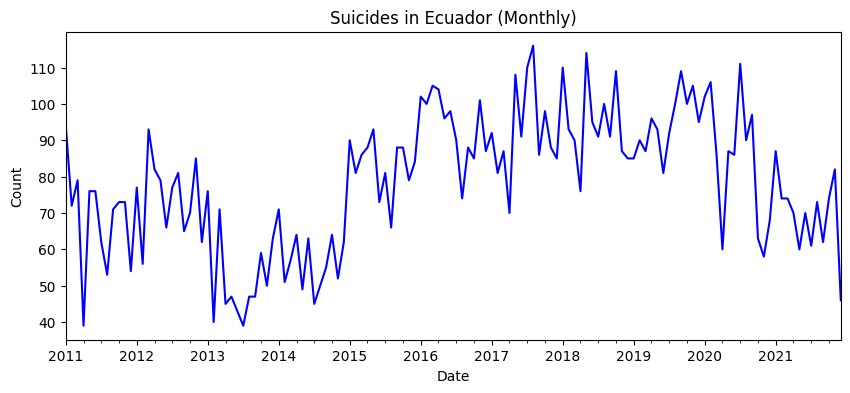

In [ ]:
mortality = mortality.copy()
mortality = mortality[mortality['date'].dt.year >= 2011]
mortality_grouped = mortality.groupby('date').size()
mortality_monthly = mortality_grouped.resample('M').sum()
mortality_monthly.plot(kind='line', figsize=(10, 4), color='blue', lw=1.5)
plt.title('Suicides in Ecuador (Monthly)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()
# Convert 'monthly_counts' Series to DataFrame
mortality_monthly = mortality_monthly.to_frame(name='Suicide_Counts')
mortality_monthly.index = pd.to_datetime(mortality_monthly.index)

In [ ]:
#Total suicides 2011-2022
mortality_monthly.sum() + 1170

Suicide_Counts    11555
dtype: int64

In [ ]:
residuals_mortality = fit_model_and_extract_residuals(mortality_monthly)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1053.233, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1097.748, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1059.105, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1051.157, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1095.819, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1053.066, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1053.100, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1049.222, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1051.132, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1051.165, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1057.182, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.74 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.461 seconds
Performing stepwise search to mi

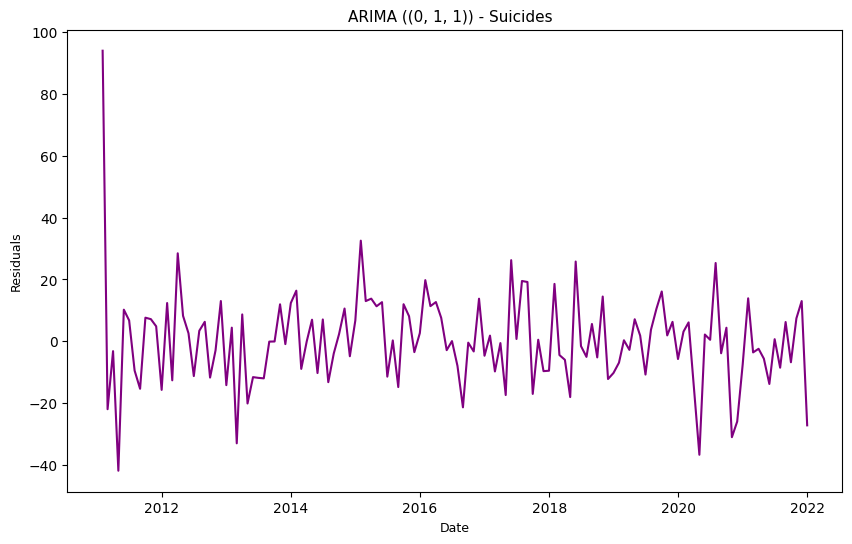

In [ ]:
plot_residuals(residuals_mortality, 'Suicides')

## Mortality by gender time series

In [ ]:
start_date = '2011-01-01'
end_date = '2021-12-31'
mortality_gender = grouped_timeseries(mortality, 'gender', start_date, end_date)
mortality_gender.index.names = ['']
mortality_gender.head()

gender,F,M
,,
2011-01-31,28,66
2011-02-28,18,54
2011-03-31,28,51
2011-04-30,13,26
2011-05-31,22,54


In [ ]:
mortality_gender.tail()

gender,F,M
2021-08-31,16,57
2021-09-30,9,53
2021-10-31,21,53
2021-11-30,24,58
2021-12-31,9,37


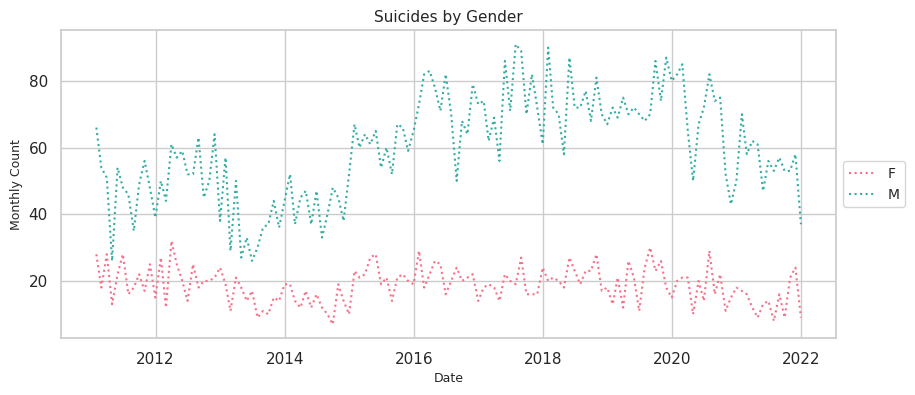

In [ ]:
plot_mortality_data(mortality_gender, 'Gender')

### Female

In [ ]:
residuals_mortality_female = fit_model_and_extract_residuals(mortality_gender['F'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=819.287, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1160.737, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=888.940, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1064.188, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=818.535, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1002.048, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=817.935, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=818.307, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=842.699, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=812.298, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=823.531, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=822.452, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=811.391, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=814.658, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=81

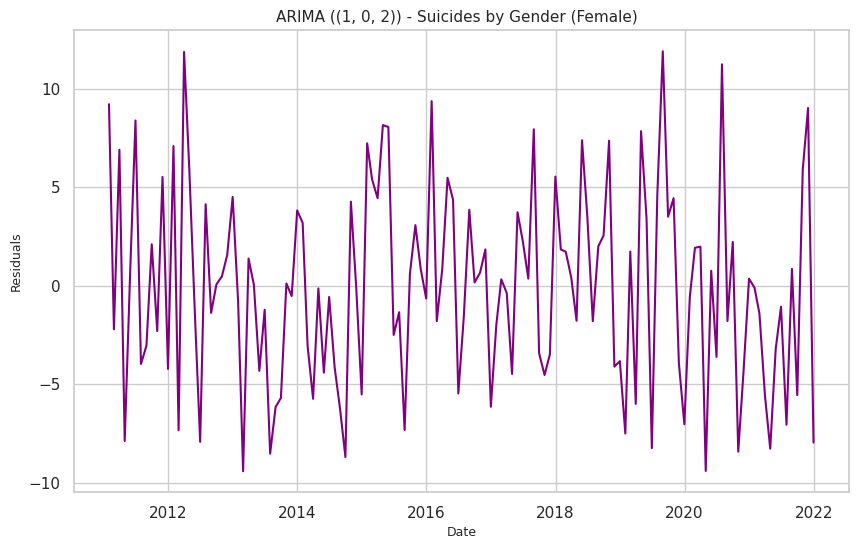

In [ ]:
plot_residuals(residuals_mortality_female, 'Suicides by Gender (Female)')

### Male

In [ ]:
residuals_mortality_male = fit_model_and_extract_residuals(mortality_gender['M'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.018, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1028.426, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=992.080, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=983.984, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1026.470, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.983, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=985.983, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=981.997, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=983.997, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=983.997, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=990.132, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.555 seconds
Performing stepwise search to minimize ai

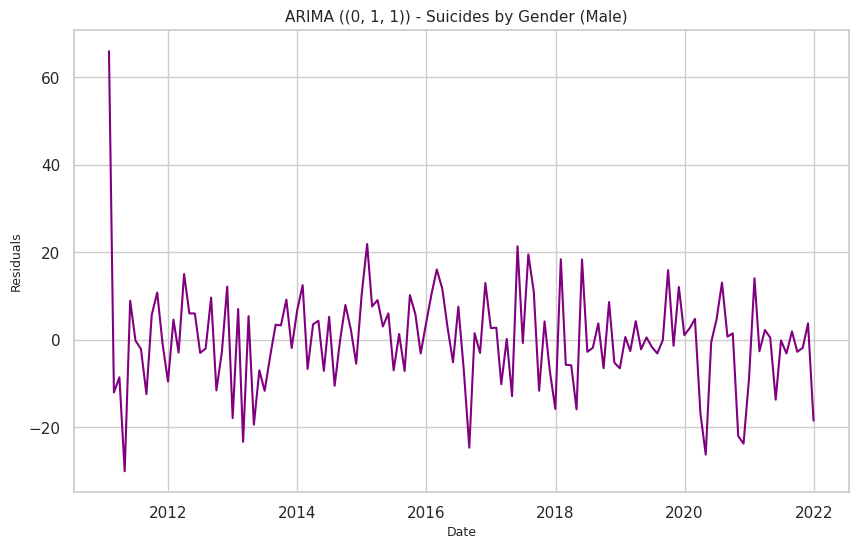

In [ ]:
plot_residuals(residuals_mortality_male, 'Suicides by Gender (Male)')

## Mortality by age range time series

In [ ]:
mortality_age = grouped_timeseries(mortality, 'age_range', start_date, end_date)
mortality_age.index.names = ['']
mortality_age.head()

age_range,Teens and Infants (0-19),Young Adults (20-39),Adults (40-64),Seniors (65+)
,,,,
2011-01-31,24,47,20,3
2011-02-28,14,34,21,3
2011-03-31,17,44,12,6
2011-04-30,11,11,14,3
2011-05-31,20,34,14,8


In [ ]:
mortality_age.tail()

age_range,Teens and Infants (0-19),Young Adults (20-39),Adults (40-64),Seniors (65+)
,,,,
2021-08-31,10,33,27,3
2021-09-30,12,36,13,1
2021-10-31,17,38,14,5
2021-11-30,14,39,15,14
2021-12-31,4,25,8,9


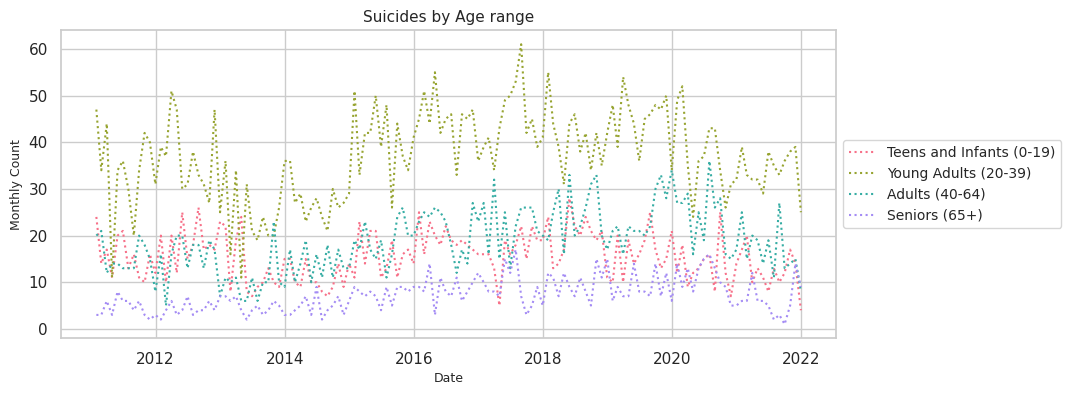

In [ ]:
plot_mortality_data(mortality_age, 'Age range')

### Teens and Infants

In [ ]:
residuals_mortality_Teens = fit_model_and_extract_residuals(mortality_age['Teens and Infants (0-19)'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=804.674, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1114.778, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=863.182, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1015.038, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=802.684, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=966.928, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=801.345, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=802.680, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=826.830, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=795.203, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=806.444, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=804.713, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=795.457, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=794.730, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=804

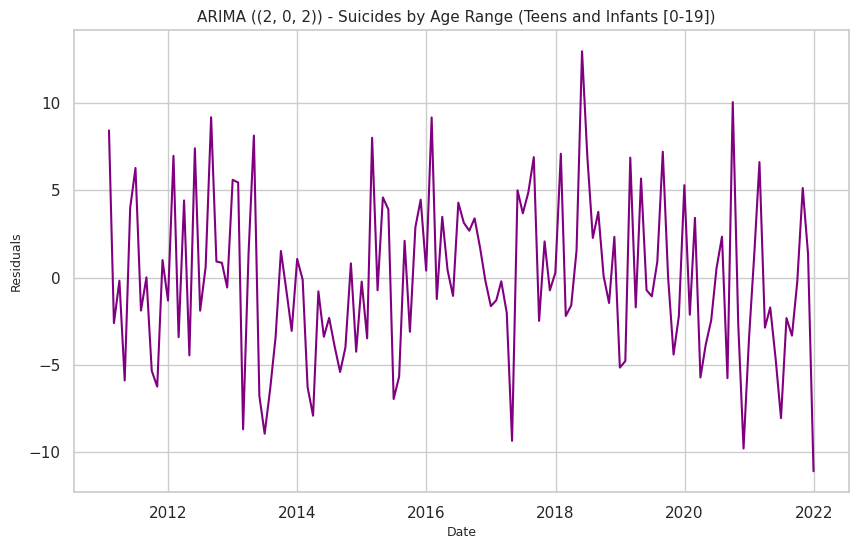

In [ ]:
plot_residuals(residuals_mortality_Teens, 'Suicides by Age Range (Teens and Infants [0-19])')

### Young Adults

In [ ]:
residuals_mortality_YoungAdults = fit_model_and_extract_residuals(mortality_age['Young Adults (20-39)'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=919.674, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=977.230, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=936.084, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=921.250, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=975.267, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=918.186, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=923.199, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=923.179, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=921.298, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=923.522, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=923.178, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=916.198, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=921.214, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=921.194, 

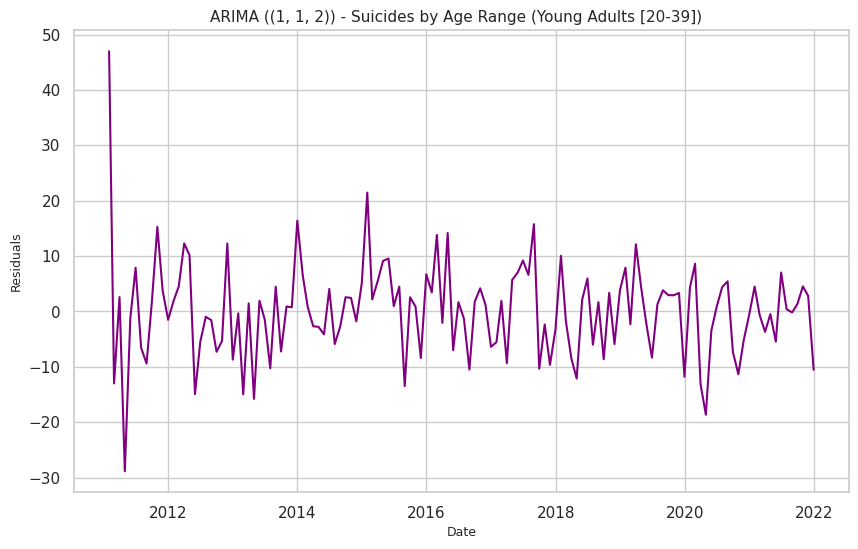

In [ ]:
plot_residuals(residuals_mortality_YoungAdults, 'Suicides by Age Range (Young Adults [20-39])')

### Adults

In [ ]:
residuals_mortality_Adults = fit_model_and_extract_residuals(mortality_age['Adults (40-64)'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=819.777, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=880.808, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=829.488, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=819.825, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=878.831, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=821.308, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=818.562, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=821.626, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=829.350, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=819.213, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=827.664, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=822.562, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=816.564, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=819.652, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=827.4

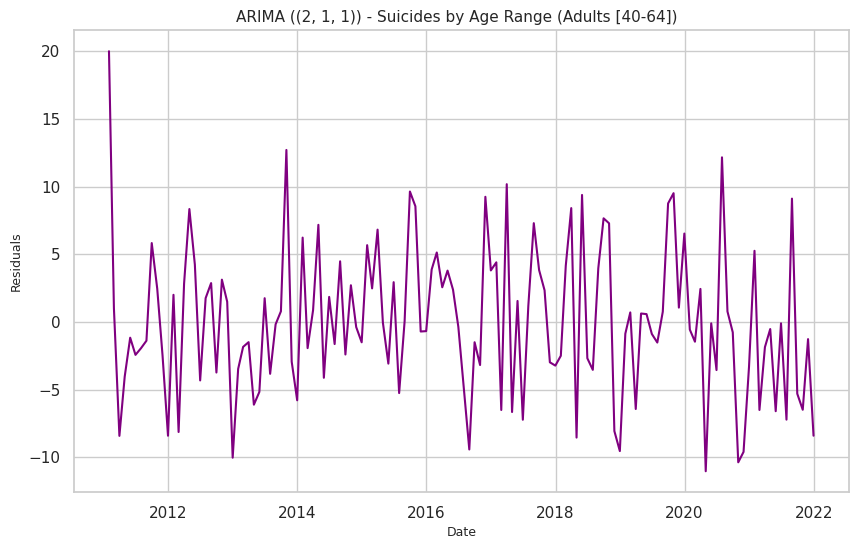

In [ ]:
plot_residuals(residuals_mortality_Adults, 'Suicides by Age Range (Adults [40-64])')

### Seniors

In [ ]:
residuals_mortality_Seniors = fit_model_and_extract_residuals(mortality_age['Seniors (65+)'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=668.031, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=728.956, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=682.875, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=668.693, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=726.974, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=671.914, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=666.428, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=670.228, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=682.631, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=667.615, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=683.014, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=668.547, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=665.490, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=668.517, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=680.7

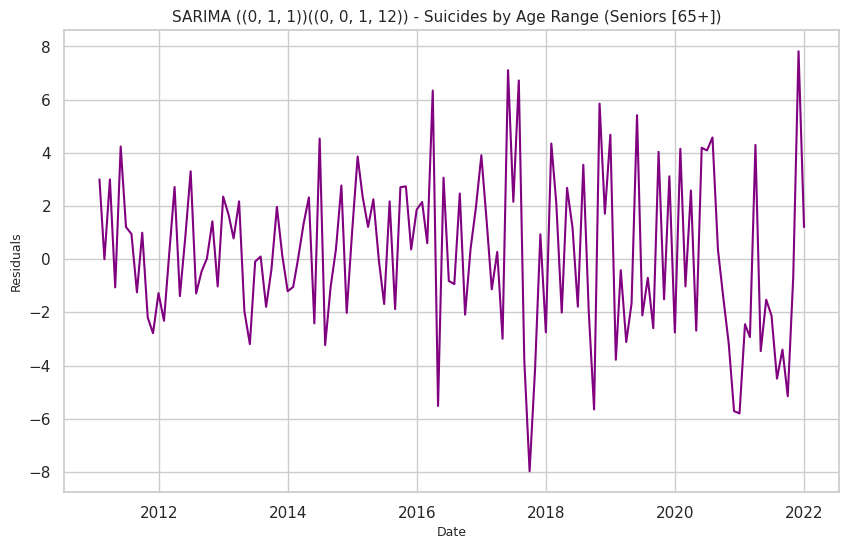

In [ ]:
plot_residuals(residuals_mortality_Seniors, 'Suicides by Age Range (Seniors [65+])')

## Mortality by region time series

In [ ]:
mortality_region = grouped_timeseries(mortality, 'region', start_date, end_date)
mortality_region.index.names = ['']
mortality_region = mortality_region.fillna(0)
mortality_region.head()

region,Amazon,Coastal and Insular,Highlands
,,,
2011-01-31,5.0,34.0,55.0
2011-02-28,8.0,26.0,38.0
2011-03-31,10.0,33.0,36.0
2011-04-30,0.0,13.0,26.0
2011-05-31,8.0,20.0,48.0


In [ ]:
mortality_region.tail()

region,Amazon,Coastal and Insular,Highlands
,,,
2021-08-31,5.0,22.0,46.0
2021-09-30,4.0,19.0,39.0
2021-10-31,6.0,22.0,46.0
2021-11-30,10.0,25.0,47.0
2021-12-31,4.0,11.0,31.0


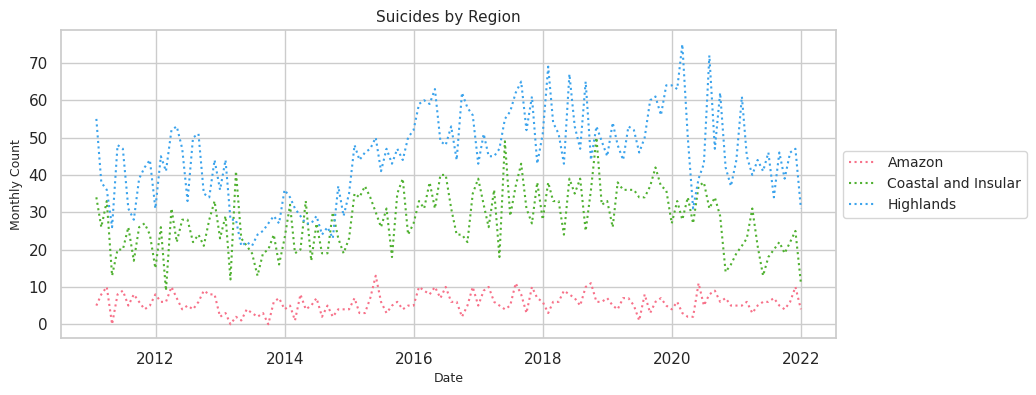

In [ ]:
plot_mortality_data(mortality_region, 'Region')

### Amazon region

In [ ]:
residuals_mortality_Amazon = fit_model_and_extract_residuals(mortality_region['Amazon'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=634.172, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=862.478, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=684.506, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=777.749, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=633.427, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=748.362, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=632.563, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=633.549, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=666.331, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=626.392, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=626.878, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=626.563, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=627.780, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=627.671, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=629.8

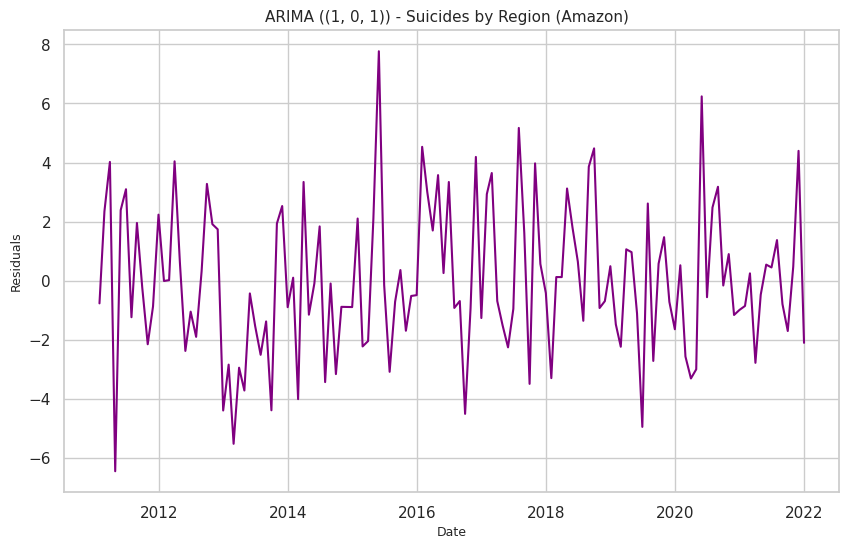

In [ ]:
plot_residuals(residuals_mortality_Amazon, 'Suicides by Region (Amazon)')

### Coastal and Insular region

In [ ]:
residuals_mortality_Coastal = fit_model_and_extract_residuals(mortality_region['Coastal and Insular'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=893.676, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=960.173, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=913.257, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=889.416, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=958.220, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=890.649, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=890.769, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=887.558, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=888.797, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=888.917, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=911.329, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.682 seconds
Performing stepwise search to minimize aic


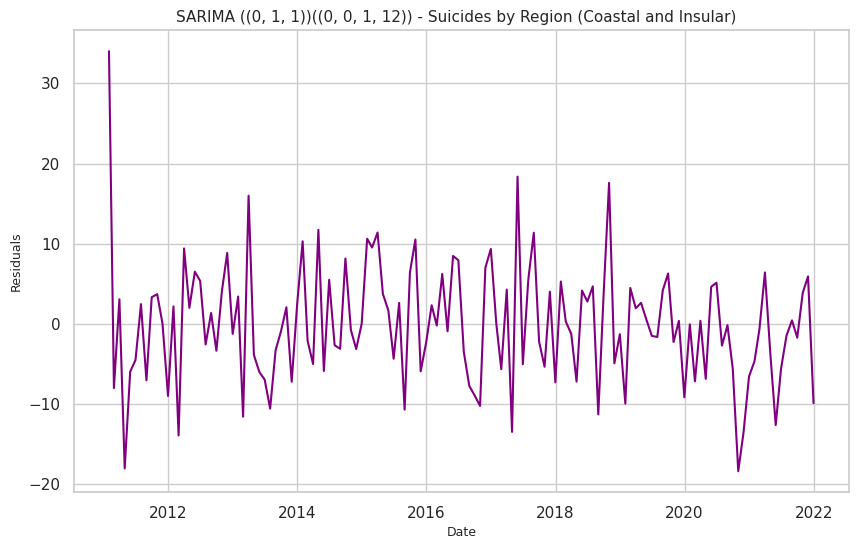

In [ ]:
plot_residuals(residuals_mortality_Coastal, 'Suicides by Region (Coastal and Insular)')

### Highlands region

In [ ]:
residuals_mortality_highlands = fit_model_and_extract_residuals(mortality_region['Highlands'].to_frame())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=948.203, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=978.835, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=959.308, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=943.818, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=976.879, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=944.327, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=944.446, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=946.321, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=941.827, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=942.334, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=942.453, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=957.346, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=944.327, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.217 seconds
Performing stepwise search to minim

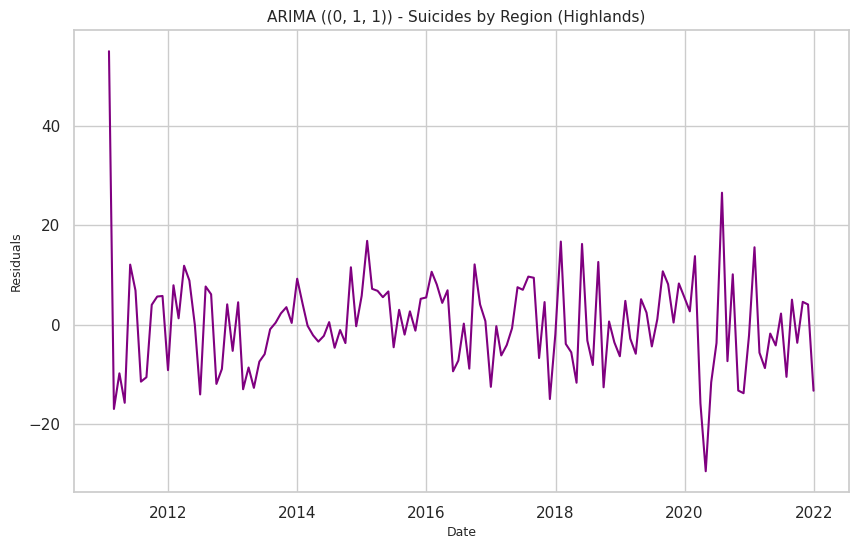

In [ ]:
plot_residuals(residuals_mortality_highlands, 'Suicides by Region (Highlands)')

# Residuals Dataframe

In [ ]:
# Dictionary of DataFrames with their respective category names
res_names = {
    'mortality': residuals_mortality,
    'mortality_female': residuals_mortality_female,
    'mortality_male': residuals_mortality_male,
    'mortality_teens': residuals_mortality_Teens,
    'mortality_young_adults': residuals_mortality_YoungAdults,
    'mortality_adults': residuals_mortality_Adults,
    'mortality_seniors': residuals_mortality_Seniors,
    'mortality_amazon': residuals_mortality_Amazon,
    'mortality_coastal': residuals_mortality_Coastal,
    'mortality_highlands': residuals_mortality_highlands,
}

# Rename the columns and concatenate the DataFrames
combined_residuals_df = pd.concat(
    [df.rename(columns={df.columns[0]: category.capitalize()}) for category, df in res_names.items()],
    axis=1
)
combined_residuals_df.index.name = 'Date'

In [ ]:
combined_residuals_df.head(10)


,Mortality,Mortality_female,Mortality_male,Mortality_teens,Mortality_young_adults,Mortality_adults,Mortality_seniors,Mortality_amazon,Mortality_coastal,Mortality_highlands
Date,,,,,,,,,,
2011-01-31,94.000000,9.213094,66.000000,8.430960,47.000000,20.000000,3.000000,-0.767161,34.000000,55.000000
2011-02-28,-21.989196,-2.206936,-11.995510,-2.609099,-12.997137,1.000548,0.000023,2.348104,-7.998619,-16.997262
2011-03-31,-3.202423,6.902525,-8.541581,-0.179590,2.602775,-8.421170,3.000011,4.021980,3.074348,-9.834973
2011-04-30,-41.893321,-7.871678,-30.016394,-5.895224,-28.863339,-4.044618,-1.061441,-6.450727,-18.012415,-15.756482
2011-05-31,10.217268,0.715238,8.971134,3.993628,-1.224284,-1.166328,4.237470,2.387704,-5.948689,12.053678
2011-06-30,6.739185,8.388451,-0.139408,6.279865,7.897317,-2.435768,1.210715,3.096648,-4.511055,6.836191
2011-07-31,-9.494651,-3.964359,-2.092236,-1.888806,-6.534762,-1.948471,0.945512,-1.236016,2.473643,-11.500585
2011-08-31,-15.385637,-3.039575,-12.391965,0.012951,-9.415028,-1.389817,-1.247939,1.955191,-7.030308,-10.609814
2011-09-30,7.624318,2.110028,5.735409,-5.340014,1.731060,5.826126,0.995850,-0.229143,3.336312,3.963239


In [ ]:
combined_residuals_df.tail(10)


,Mortality,Mortality_female,Mortality_male,Mortality_teens,Mortality_young_adults,Mortality_adults,Mortality_seniors,Mortality_amazon,Mortality_coastal,Mortality_highlands
Date,,,,,,,,,,
2021-03-31,-2.441770,-5.547502,2.275797,-2.866839,-3.688987,-1.862984,4.296138,-2.780078,6.418448,-8.768077
2021-04-30,-5.650397,-8.262873,0.520785,-1.709639,-0.488706,-0.525631,-3.459735,-0.474316,-3.512743,-1.825916
2021-05-31,-13.819115,-3.203757,-13.651989,-4.693344,-5.453260,-6.598158,-1.524375,0.544067,-12.612228,-4.213223
2021-06-30,0.659633,-1.060825,-0.122845,-8.052052,7.030760,-0.103087,-2.121386,0.448881,-5.613071,2.200540
2021-07-31,-8.554153,-7.044770,-3.082090,-2.321864,0.403242,-7.221331,-4.494637,1.375013,-1.467196,-10.537859
2021-08-31,6.218231,0.858527,1.940415,-3.327029,-0.180225,9.110359,-3.403615,-0.791764,0.444082,4.998160
2021-09-30,-6.797085,-5.541545,-2.703331,-0.238280,1.334732,-5.306495,-5.156610,-1.702287,-1.719538,-3.678992
2021-10-31,7.405837,5.894220,-1.806482,5.131742,4.528978,-6.492797,-0.655211,0.476602,3.881289,4.555508
2021-11-30,13.005620,9.019389,3.792831,1.351040,2.794362,-1.271515,7.820737,4.396526,5.926848,4.026890


In [ ]:
# Export the DataFrame to a CSV file delimited by pipes '|'
combined_residuals_df.to_csv('/content/drive/MyDrive/Diversa/PUCE/Mortality_residuals.csv', sep='|', index=True)